This notebook is used to compare GCM data with AWS data, or one GCM against another to look for apparent biases or calibrate parameters to match data. This includes code to calibrate kp (multiplicative precipitation factor) to field winter mass balance data.

In [1]:
import xarray as xr 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import numpy as np
import scipy.stats as ss

In [3]:
fp = '/home/claire/research/climate_data/MERRA2/'
latlon = [[63.281,-145.427,'Gulkana'],
          [60.412,-148.908,'Wolverine'],  # Wolverine 01.09162
          [60.666,-139.114,'Kaskawulsh']] # Kaskawulsh 01.16201

for l in latlon:
    flat = str(int(np.floor(l[0]/10)*10))
    flon = str(int(np.floor(l[1]/10)*10))
    ds = xr.open_dataset(fp+f'T2M/MERRA2_T2M_{flat}_{flon}.nc')
    ds = ds.sel(lat=l[0],lon=l[1],method='nearest')
    print(l[2],'Average Temp (C): ',ds.T2M.mean().values - 273.15)
print()
for l in latlon:
    ds = xr.open_dataset(fp+f'PRECTOTCORR/MERRA2_PRECTOTCORR_{flat}_{flon}.nc')
    ds = ds.sel(lat=l[0],lon=l[1],method='nearest')
    ds = ds.resample(time='YE').sum() / 1000 * 3600
    print(l[2],'Annual Average Precip (m): ',ds.PRECTOTCORR.mean().values)

Gulkana Average Temp (C):  -5.913671874999977
Wolverine Average Temp (C):  0.31734619140627274
Kaskawulsh Average Temp (C):  -9.597814941406227

Gulkana Annual Average Precip (m):  0.42931423
Wolverine Annual Average Precip (m):  2.404062
Kaskawulsh Annual Average Precip (m):  1.8929135


In [88]:
# INPUTS
var = 'temp'      # Variable to compare
compare_by = 'region'   # 'region', 'GCM'
GCM = 'MERRA2'  # GCM to extract ('MERRA2','ERA5',' or 'BOTH')
start = pd.to_datetime('2003-01-01 00:00')
end = pd.to_datetime('2018-12-31 00:00')
res = 'd'
resample = True
plothour = 12
timezone = pd.Timedelta(hours=-8)

# necessary initialization
units_checked = False
all_vars = {'temp':{'MERRA2':'T2M','ERA5':'t2m'},
            'tp':{'MERRA2':'PRECTOTCORR','ERA5':'tp'},
            'rh':{'MERRA2':'RH2M','ERA5':'rh'},
            'SWin':{'MERRA2':'SWGDN','ERA5':'ssrd'},
            'LWin':{'MERRA2':'LWGAB','ERA5':'strd'},
            'uwind':{'MERRA2':'U2M','ERA5':'u10'},
            'vwind':{'MERRA2':'V2M','ERA5':'v10'},
            'sp':{'MERRA2':'PS','ERA5':'sp'},
            'tcc':{'MERRA2':'CLDTOT','ERA5':'tcc'},
            'bcwet':{'MERRA2':'BCWT002'},'bcdry':{'MERRA2':'BCDP002'},
            'dustwet':{'MERRA2':'DUWT002'},'dustdry':{'MERRA2':'DUDP002'}}

In [89]:
# GET GLACIER CENLAT
# fill out glac_no and glacier_name for getting AWS data
glac_no = '01.16195' 
glacier_name = 'South'
# glac_no = '15.03733'
# glacier_name = 'Khumbu'
region = glac_no[:2]

In [90]:
# FILEPATHS
fp_clim = '/home/claire/research/climate_data/'
fp_MERRA2 = os.path.join(fp_clim,'MERRA2/VAR/MERRA2_VAR_LAT_LON.nc')
fp_ERA5 = os.path.join(fp_clim,'ERA5/ERA5_hourly/ERA5_VAR_hourly.nc')
fp_AWS = os.path.join(fp_clim,'AWS/Preprocessed/south/south2280_2008.csv') # 'AWS/Gulkana/LVL2/gulkana1480_hourly_LVL2.csv'
list_RGI = os.listdir('/home/claire/research/RGI/rgi60/00_rgi60_attribs/')
for file in list_RGI:
    if region in file:
        fp_RGI = '/home/claire/research/RGI/rgi60/00_rgi60_attribs/' + file


In [91]:
# extract lat/lon of glacier
glacier_table = pd.read_csv(fp_RGI)
glacier_table = glacier_table.loc[glacier_table['RGIId'] == 'RGI60-'+glac_no]
cenlat = glacier_table['CenLat'].to_numpy()[0]
cenlon = glacier_table['CenLon'].to_numpy()[0]

In [92]:
def get_point_ds(GCM,var,start=start,end=end):
    """
    Selects the closest latitude and longitude gridcell
    from a GCM dataset to the input cenlat, cenlon coordinates.
    Also returns the geopotential of that gridcell converted
    to elevation units (m)
    """
    # open GCM dataset
    if GCM in ['MERRA2']:
        start_M = start + pd.Timedelta(minutes=30) - timezone
        end_M = end + pd.Timedelta(minutes=30) - timezone
        file_lat = str(int(np.floor(cenlat/10)*10))
        file_lon = str(int(np.floor(cenlon/10)*10))
        fn_MERRA2 = fp_MERRA2.replace('LAT',file_lat).replace('LON',file_lon)
        fn_MERRA2 = fn_MERRA2.replace('VAR',all_vars[var]['MERRA2'])
        ds = xr.open_dataset(fn_MERRA2)
        ds = ds.sel(time=pd.date_range(start_M,end_M,freq='h'))
        ds = ds.interp(time=pd.date_range(start-timezone,end-timezone,freq='h'))
        ds.coords['time'] = pd.date_range(start,end,freq='h')
        eds = xr.open_dataset('~/research/climate_data/MERRA2/MERRA2constants.nc4')
        latname = 'lat'
        lonname = 'lon'
        elevname = 'PHIS'

    elif GCM in ['ERA5']:
        fn_ERA5 = fp_ERA5.replace('VAR',var)
        ds = xr.open_dataset(fn_ERA5)
        eds = xr.open_dataset('~/research/climate_data/ERA5/ERA5_hourly/ERA5_geopotential.nc')
        latname = 'latitude'
        lonname = 'longitude'
        elevname = 'z'

    # get latitude and longitude of nearest GCM point
    datalat = ds.coords[latname][:].values
    datalon = ds.coords[lonname][:].values
    lat_nearidx = np.abs(cenlat - datalat).argmin()
    lon_nearidx = np.abs(cenlon - datalon).argmin()
    lat = datalat[lat_nearidx]
    lon = datalon[lon_nearidx]

    if GCM == 'ERA5':
        lat = lat.round(2)
        lon = lon.round(2)
        if var == 'tcc':
            lat = lat.round(1)
            lon = lon.round(1)

    # select dataset by closest lat/lon to glacier center
    ds = ds.sel({latname:lat,lonname:lon}).drop_vars([latname,lonname])
    eds = eds.sel({latname:lat,lonname:lon})
    elev = eds[elevname].to_numpy()[0] / 9.81
    return ds,elev

In [93]:
# input processing of AWS dataset
AWS_elev = 2280
df_AWS = pd.read_csv(fp_AWS,index_col=0)
df_AWS.index = pd.to_datetime(df_AWS.index)
# df_AWS.fillna({'Precip_Weighing_Incremental':df_AWS['Precip_Stage_Incremental']*1.48},inplace=True)
if start >= df_AWS.index[0] and end <= df_AWS.index[len(df_AWS)-1]:
    df_AWS = df_AWS.loc[pd.date_range(start,end,freq='h')]
else:
    start = pd.to_datetime(df_AWS.index[0])
    end = pd.to_datetime(df_AWS.index[len(df_AWS)-1])

# df_AWS = df_AWS['Precip_Weighing_Incremental']
# df_AWS = df_AWS['site_temp_USGS']
df_AWS = df_AWS[var]

In [94]:
ds_GCM,elev = get_point_ds(GCM,var,start,end)

In [95]:
# UNITS
if not units_checked:
    if var == 'tp':
        df_AWS['tp'] = df_AWS['Precip_Weighing_Incremental'] / 1000
        ds_GCM = ds_GCM * 3600 / 1000
    elif var == 'temp':
        ds_GCM = ds_GCM - 273.15
        print(f'Adjusting to {AWS_elev - elev:.1f} m elevation change from geopotential to the AWS elevation')
        print(f'(temperature change of {-0.0065*(AWS_elev - elev) :.3f} C)')
        ds_GCM = ds_GCM - 0.0065*(AWS_elev - elev)
    elif var in ['SWin','LWin']:
        df_AWS /= 3600

Adjusting to 297.6 m elevation change from geopotential to the AWS elevation
(temperature change of -1.935 C)


In [96]:
ds_GCM['hour'] = (['time'],pd.to_datetime(ds_GCM['time'].values).hour)
df_AWS = df_AWS.to_frame().assign(hour=pd.to_datetime(df_AWS.index).hour)

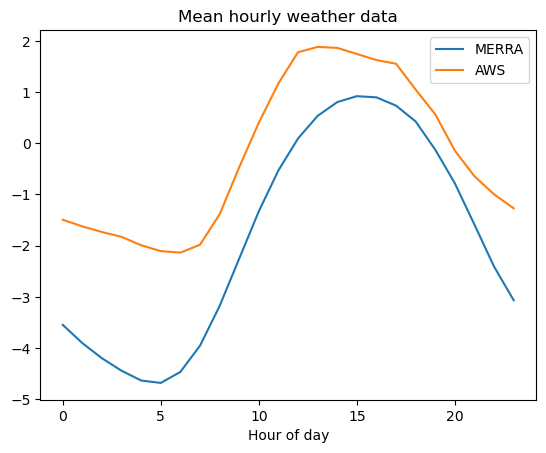

In [97]:
hourly_GCM = []
hourly_AWS = []
for hour in np.arange(24):
    ds_hour = ds_GCM.where(ds_GCM['hour'] == hour,drop=True)
    vardata = ds_hour[all_vars[var]['MERRA2']].values
    hourly_mean = np.mean(vardata[~np.isnan(vardata)])
    hourly_GCM.append(hourly_mean)

    df_hour = df_AWS.loc[df_AWS['hour'] == hour]
    vardata = df_hour[var].to_numpy()
    hourly_mean = np.mean(vardata[~np.isnan(vardata)])
    hourly_AWS.append(hourly_mean)
plt.plot(np.arange(24),hourly_GCM,label='MERRA')
plt.plot(np.arange(24),hourly_AWS,label='AWS')
plt.legend()
plt.ylabel('')
plt.xlabel('Hour of day')
plt.title('Mean hourly weather data')
plt.show()

In [98]:
# RESAMPLE
if resample:
    if var in ['tp']:
        df_AWS = df_AWS.resample(res).sum()
        ds_GCM = ds_GCM.resample(time=res).sum()
    if var in ['bcwet','bcdry','dustwet','dustdry']:
        ds_GCM = ds_GCM.resample(time=res).sum() * 3600
    else:
        df_AWS = df_AWS.resample(res).mean()
        ds_GCM = ds_GCM.resample(time=res).mean()
        if len(df_AWS.index) != len(ds_GCM.coords['time']):
            df_AWS = df_AWS.iloc[1:]
else:
    plothour = '12'
    starthour = str((start+pd.Timedelta(days=1)).date()) + f' {plothour}:00'
    endhour = str((end-pd.Timedelta(days=1)).date()) + f' {plothour}:00'
    timehour = pd.date_range(starthour,endhour,freq='d')
    ds_GCM = ds_GCM.sel(time=timehour)
    df_AWS = df_AWS.loc[timehour]

In [99]:
# ds_GCM_AK = ds_GCM.copy()
# ds_GCM_HMA = ds_GCM.copy()

In [100]:
# df_AWS = df_AWS.resample('YE').mean()
# ds_GCM = ds_GCM.resample(time='YE').mean()
# ds_GCM_ERA5 = ds_GCM_ERA5.resample(time='YE').mean()

In [101]:
plot_GCM = ds_GCM[all_vars[var][GCM]].values
df_AWS = df_AWS.fillna(0)
plot_AWS = df_AWS.to_numpy() #['Precip_Weighing_Incremental'].to_numpy()
if var == 'tp':
    plot_GCM = np.cumsum(plot_GCM)
    plot_AWS = np.cumsum(plot_AWS)
ttest = ss.ttest_rel(plot_AWS,plot_GCM,alternative='two-sided')
p = ttest.pvalue
print('Means:')
print('  ttest pvalue:', p)
if p < 0.05:
    result = 'significantly different'
else:
    result = 'not different'
print('     ',result)

ValueError: Array shapes are incompatible for broadcasting.

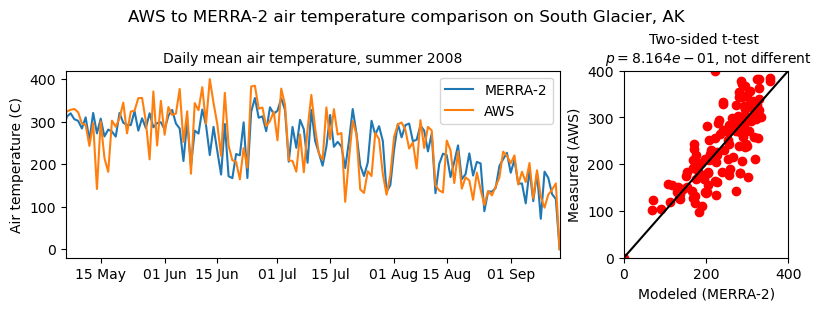

In [ ]:
fig,[ax1,ax2] = plt.subplots(1,2,width_ratios=[3,1],figsize=(8,3),layout='constrained')
ax1.plot(ds_GCM['time'],plot_GCM,label='MERRA-2')
# plt.plot(ds_GCM['time'],ds_GCM_HMA[all_vars[var][GCM]].values,label='HMA')
ax1.plot(df_AWS.index,plot_AWS,label='AWS')
ax1.legend()
ax2.scatter(plot_GCM,plot_AWS,label='AWS',c='r')
maxval = max(np.max(plot_AWS),np.max(plot_GCM))
minval = min(np.min(plot_AWS),np.min(plot_GCM))
ax2.plot([0,maxval],[0,maxval],c='black')
ax1.set_ylabel('Air temperature (C)')
ax2.set_ylabel('Measured (AWS)')
ax2.set_xlabel('Modeled (MERRA-2)')
date_form = mpl.dates.DateFormatter('%d %b')
ax1.xaxis.set_major_formatter(date_form)
ax1.set_xlim([start+pd.Timedelta(days=1),end])
ax2.set_xlim([minval,maxval])
ax2.set_ylim([minval,maxval])
ax1.set_title('Daily mean air temperature, summer 2008',fontsize=10)
ax2.set_title(f'Two-sided t-test \n $p={p:.3e}$, {result}',fontsize=10)
fig.suptitle('AWS to MERRA-2 air temperature comparison on South Glacier, AK')
plt.show()

In [354]:
print(np.mean(plot_AWS),np.mean(plot_GCM))

-0.32034172179633075 -1.9546454868823966


Means:
  ttest pvalue: 0.4851913276015456
    not different


In [131]:
def monthly_means(df):
    df['Date'] = pd.to_datetime(df.index)
    df['Month'] = df['Date'].dt.month
    df_monthly = df.groupby('Month').mean()
    return df_monthly

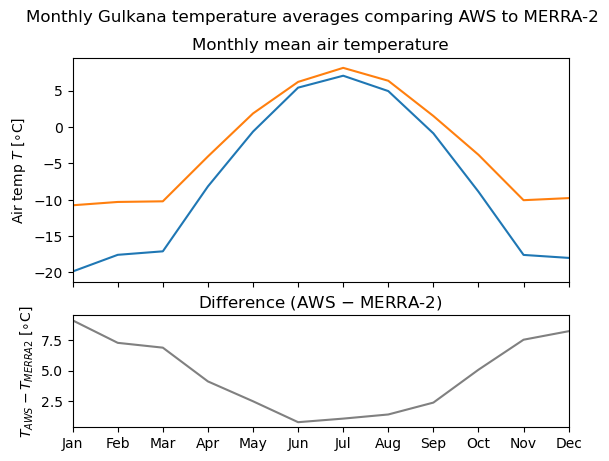

In [132]:
fig,ax = plt.subplots(2,height_ratios=[2,1],sharex=True)
monthnames = [m.month_name()[:3] for m in df_AWS.index[:12]]
df_GCM = ds_GCM.to_dataframe().rename(columns={'T2M':'temp'})
monthly_GCM = monthly_means(df_GCM)
df_AWS = df_AWS.to_frame().rename(columns={'site_temp_USGS':'temp'})
monthly_AWS = monthly_means(df_AWS)
diff = df_AWS['temp'] - df_GCM['temp']
monthly_diff = monthly_means(diff.to_frame())

ax[0].plot(monthnames,monthly_GCM['temp'],label='MERRA2')
ax[0].plot(monthnames,monthly_AWS['temp'],label='AWS')
ax[0].set_ylabel('Air temp $T$ [$\circ$C]')
ax[0].set_title('Monthly mean air temperature')
ax[1].plot(monthnames,monthly_diff['temp'],color='gray')
ax[1].set_ylabel('$T_{AWS}-T_{MERRA2}$ [$\circ$C]')
ax[1].set_title('Difference (AWS $-$ MERRA-2)')
ax[1].set_xlim(monthnames[0],monthnames[11])
fig.suptitle('Monthly Gulkana temperature averages comparing AWS to MERRA-2')
plt.show()

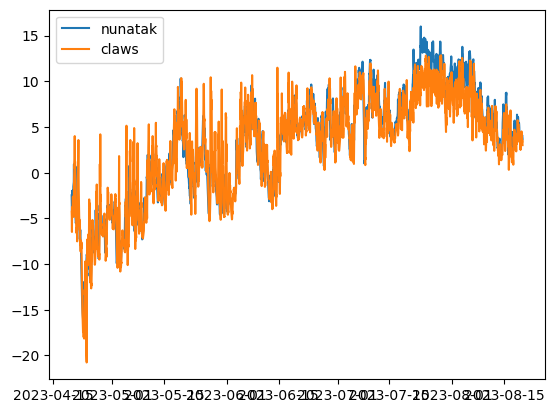

0.003956071264485794


In [32]:
df = pd.read_csv('/home/claire/research/climate_data/AWS/Gulkana/gulkana_nunatak_22_23.txt',sep='\t',skiprows=33).iloc[1:]
df['temp'] = df['316710_00020']
df.index = pd.to_datetime(df['datetime'])
df_nunatak = df['temp'].astype(float)
df_nunatak = df_nunatak.resample('h').mean()
df = pd.read_csv('/home/claire/research/climate_data/AWS/Gulkana/gulkana-d-23.csv',skiprows=2)
df['temp'] = (df['Temp']-32)*5/9
df.index = pd.to_datetime(df['Datetime'])
df_claws = df['temp']
dates = pd.date_range('2023-04-20 00:00','2023-08-20 00:00',freq='h')
df_nunatak = df_nunatak.loc[dates]
df_claws = df_claws.loc[dates]
plt.plot(dates,df_nunatak,label='nunatak')
plt.plot(dates,df_claws,label='claws')
plt.legend()
plt.show()
print(np.mean(df_nunatak - df_claws) / (1852 - 1725))

In [137]:
monthly_diff['diff'] = monthly_diff['temp']
monthly_diff['diff'].to_csv('/home/claire/research/PyGEM-EB/pygem_eb/data/Gulkana_MERRA2_temp_diff.csv')

In [143]:
df = pd.read_csv('/home/claire/research/PyGEM-EB/pygem_eb/data/Gulkana_MERRA2_temp_diff.csv',index_col=0)

In [139]:
ds = xr.open_dataset('~/research/climate_data/MERRA2/T2M/MERRA2_T2M_60_-150.nc').sel(lon=-150.0,lat=60)
print(ds)

<xarray.Dataset>
Dimensions:  (time: 210384)
Coordinates:
    lat      float64 60.0
    lon      float64 -150.0
  * time     (time) datetime64[ns] 2000-01-01T00:30:00 ... 2023-12-31T23:30:00
Data variables:
    T2M      (time) float32 ...


In [376]:
df=pd.read_csv('/home/claire/research/climate_data/AWS/Gulkana/LVL2/gulkana1480_hourly_LVL2.csv')
df.index = pd.to_datetime(df['local_time'])
all_temps = []
yearly_avgs = []
for year in np.arange(2000,2019):
    all_dates = []
    for day in np.arange(18,23):
        start = pd.to_datetime(f'{year}/06/{day} 10:00')
        end = pd.to_datetime(f'{year}/06/{day+1} 20:00')
        dates = pd.date_range(start,end,freq='h')
        all_dates.append(dates)
    all_dates = np.array(all_dates).ravel()
    all_temps.append(df['site_temp_USGS'].loc[all_dates])
    yearly_avgs.append(np.max(df['site_temp_USGS'].loc[all_dates]))
all_temps = np.array(all_temps).ravel()
all_temps = all_temps[~np.isnan(all_temps)]
print(np.mean(all_temps))

8.061015873015874


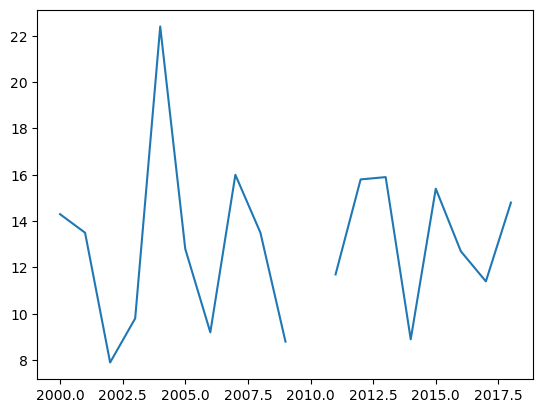

In [377]:
plt.plot(np.arange(2000,2019),yearly_avgs)

In [361]:
df

,local_time,site_temp_min,site_temp_max,site_temp_WMO,site_temp_USGS,Precip_Weighing_Incremental,Precip_Stage_Incremental,RelHum,WindSpeed,WindGustSpeed,WindDir,VecAvgWindDir
local_time,,,,,,,,,,,,
1995-10-03 11:00:00,1995/10/03 11:00,0.3,1.6,0.9,0.9,NaN,NaN,NaN,1.4,NaN,NaN,NaN
1995-10-03 12:00:00,1995/10/03 12:00,1.6,2.1,1.9,1.9,NaN,NaN,NaN,1.1,NaN,NaN,NaN
1995-10-03 13:00:00,1995/10/03 13:00,1.3,2.2,1.8,1.8,NaN,NaN,NaN,0.7,NaN,NaN,NaN
1995-10-03 14:00:00,1995/10/03 14:00,0.5,1.2,0.8,0.7,NaN,NaN,NaN,7.2,NaN,NaN,NaN
1995-10-03 15:00:00,1995/10/03 15:00,0.6,0.8,0.7,0.7,NaN,NaN,NaN,7.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-26 12:00:00,2019/04/26 12:00,-5.9,-5.6,-5.8,-5.8,0.0,NaN,NaN,10.1,12.0,NaN,NaN
2019-04-26 13:00:00,2019/04/26 13:00,-5.5,-5.1,-5.3,-5.3,0.0,NaN,NaN,10.2,11.8,NaN,NaN
2019-04-26 14:00:00,2019/04/26 14:00,-4.9,-4.7,-4.8,-4.8,0.0,NaN,NaN,9.8,11.5,NaN,NaN
